<a href="https://colab.research.google.com/github/mwelland/ENGPYHS_3NM4/blob/main/Initial_value_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial value problems - Explicit methods

Initial Value Problems are characterised by knowledge of boundary conditions only on one side of the domain. This is typically (but not necessarily) for time-dependent equations, thus the name and following nomenclature.

e.g.:
 $$\frac{dy}{dt} = y, \quad y(t=0) = 1$$
 or
 $$\frac{d^2 y}{dt^2} = -g, \quad y(t=0) = 1000, y'(t=0) = 0$$

In these cases we are forced to start at $t=0$ and *time-step* forward until we reach our goal time. This has several implications:


*   Error in the soultion will accumulate with successive steps.
*   Numerical noise may destabilize the solution scheme.
*   Time stepping must resolve the time-scale of the physics we are looking at.
*   The time-scale may change mid-problem.
*   We will build up a *history* of steps as we go.

As with analytical methods, on a high level we obtain a solution by *integrating* the differential equation up until the point of interest. For this reason, solving IVPs are often called *time integrators* and much of the analysis carries over.

## Error analysis

As usual, we will discuss error in the context of truncation error. As with other integration schemes,
* *Local truncation error* occurs over the time-step due to the approximation of $y_{i+1}$.
* *Global / propogated truncation error* is the accumulation of propogated local truncation error and results in overall error of the approximation to the true solution.

Later we will discuss a new phenomenon, stability and *stiffness*.

We will be using the Taylor expansion to analyse error and help deevelop our numerical schemes. Higher accuracy is achieved through estimation of the higher order derivatives. There are two classes of methods that are applied:
* Single step methods - Uses information about the current time step
* Multistep methods - Uses the history of time steps

##Runge-Kutta methods

The Runge-Kutta methods are a class of techniques where the next time step is calculated from the *current time step* and an estimate of its *slope* (rate of change). Increased accuracy is achieved through approximating higher order derivatives to improve our timestep. Since we don't generally have that information, we can sample the function at different steps to approximate them. This is the basis for the Runge-Kutta family of methods.  

Consider the Taylor expansion,
$$\begin{align}
y_{i+1} &= y_i + y_i^\prime h + \frac{y_i^{\prime\prime}}{2}h^2 + \frac{y'''}{6}h^3 + \cdots \\
&= y_i + f(x_i,y_i) h + \frac{f(x_i,y_i)^\prime}{2}h^2 + \frac{f(x_i,y_i)^{\prime\prime}}{6}h^3 + \cdots \\
&\approx y_i + h \sum_{n=1}^s a_n k_n
\end{align}$$

where the last line is the general form of the Runge-Kutta methods. $a_n$ are a set of constants and $k_n$ are the function evaluated at different positions in the interval. The goal is clearly to match
$$\sum_{n=1}^s a_n k_n \approx f(x_i,y_i) + \frac{f(x_i,y_i)^\prime}{2}h + \frac{f(x_i,y_i)^{\prime\prime}}{6}h^2 + \cdots $$

in so far as possible with a series truncated in $s$ terms (called stages).

Let's build up to the general form step by step.


### Forward Euler method

The Forward Euler method (aka: Euler-Cauchy / point-slope method, Explicit Euler) is the simplest Runge-Kutta method. One simply takes the slope at the current point, which is given in the differential equation, and assumes it is constant over the step:

Given, $$ \frac{dy}{dx} = f(x, y) $$
the next time step is:
$$ y_{i+1} = y_i + f(x_i, y_i) h$$

which is simply the left Riemann sum, and similarly the error is $O(h^2)$ over the step, and $O(h)$ over the full solution.

###Heun's method

Now that we have a value for $y_{i+1}$ is there a way we can use the *prediction* to *correct* itself? Heun's method does exactly this and is called a **predictor-corrector** algorithm as a result.

Consider:

$$ \frac{dy}{dx} = f(x, y) $$
make a prediction,
$$ y^0_{i+1} = y_i + f(x_i, y_i) h$$
Now take the average of the slopes:
$$\begin{align}
\bar{y}' &= \frac{y_i+y_{i+1}}{2} \\
&= \frac{f(x_i,y_i)+f(x_{i+1}, y^0_{i+1})}{2}
\end{align} $$
which is used in the corrector:
$$ y_{i+1} = y_i + \frac{f(x_i,y_i)+f(x_{i+1}, y^0_{i+1})}{2} h$$


This is interesting since one could repeat the predictor-corrector cycle with the intention of converging towards the correct answer, but we will see this is a bad idea:



#### Example: Heun's method with multiple predictor-corrector cycles

Integrate
$$y' = 4 e^{0.8 x}-0.5 y$$
with
$$ y(0)=2$$
using Heun's method with 1 and 15 predictor-corrector cycles.


In [1]:
import numpy as np

def f(x, y):
  return 4 * (2.71828 ** (0.8 * x)) - 0.5 * y

def heuns_method(x0, y0, h, t, iterations):
  """
  Applies Heun's method to approximate the solution of a differential equation.

  Args:
    x0: The initial x value.
    y0: The initial y value.
    h: The step size.
    t: The target time for the approximation.
    iterations: The number of iterations for the predictor-corrector cycle.

  Returns:
    The approximate y value at time t.
  """
  x = x0
  y = y0
  while x < t:
    y_pred = y + h * f(x, y)
    y_next = y + h * (f(x, y) + f(x + h, y_pred)) / 2
    for _ in range(iterations - 1):
      y_pred = y_next
      y_next = y + h * (f(x, y) + f(x + h, y_pred)) / 2

    y = y_next
    x += h
    print("Time ", x, ", approximation, ", y_next, ', True ,', 4/1.3*(np.exp(.8*x)-np.exp(-.5*x))+2*np.exp(-.5*x))
  return y


# Initial conditions
x0 = 0
y0 = 2

# Step size and target time
h = 1
t = 4

# Estimate integral with Heun's method, iterating once
print("Heun's method with 1 iteration")
y_approx_once = heuns_method(x0, y0, h, t, 1)

# Estimate integral with Heun's method, iterating 15 times
print("\nHeun's method with 15 iterations")
y_approx_15 = heuns_method(x0, y0, h, t, 15)

Heun's method with 1 iteration
Time  1 , approximation,  6.701079461759733 , True , 6.194631377209372
Time  2 , approximation,  16.319768581929353 , True , 14.84392190764649
Time  3 , approximation,  37.199199627848756 , True , 33.67717176796817
Time  4 , approximation,  83.33761313495894 , True , 75.33896260915857

Heun's method with 15 iterations
Time  1 , approximation,  6.360863570675189 , True , 6.194631377209372
Time  2 , approximation,  15.302225064771143 , True , 14.84392190764649
Time  3 , approximation,  34.74323213193692 , True , 33.67717176796817
Time  4 , approximation,  77.73495685652544 , True , 75.33896260915857


Unfortunatley, Heun's method does converge but not necessarily to the correct answer!

#### The Trapezoid rule

In the case that the slope doesn't depend on the function value, $y'(x) = f(x)$ the predictor can be calcualted directly, eliminating the cycle:

$$ y_{i+1} = y_i + \frac{f(x_i)+f(x_{i+1})}{2} h$$

which is mearly the trapezoid rule which carries $O(h^3)$ accuracy locally and $O(h^2)$ globally.

### The Midpoint method

Recall from the discussion on on differentiation / integration that information from the midpoint was often superior that of either endpoint (in isolation) as over/under estimates tend to cancel.

As an alternative to Heun's predictor-corrector method, let's subdivide the interval and find the slope at the *midpoint*. To do this, take a half step:

$$ y_{i+1/2} = y_i + f(x_i,y_i) \frac{h}{2} $$

then use the slope at the midpoint, $y'_{i+1/2} = f(x_{i+1/2},y_{i+1/2})$ to estimate the full step:

$$ y_{i+1} = y_i + f(x_{i+1/2},y_{i+1/2}) h $$

which has $O(h^3)$ local / $O(h^2)$ global error.




## Explicit Runge-Kutta methods

We are now in a position to generalize the RK methods. Recalling:

$$ y_{i+1} \approx y_i + h \sum_{n=1}^s a_n k_n$$

For the *explicit* set of RK methods,

$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + p_2 h, y_i + [q_{21}k_1] h) \\
k_3 &= f(x_i + p_3 h, y_i + [q_{31}k_1 + q_{32}k_2] h) \\
\vdots\\
k_s &= f(x_i + p_s h, y_i + [q_{s1}k_1 + q_{s2}k_2 ... q_{s,s-1} k_{s-1}] h) \\
\end{align} $$
The $p_n$ and $q_{nm}$, along with $a_n$ are constants and determine the type of RK method.

Note RK-1 is simply the Forward Euler equation.


### Butcher Tableaus

Noting that $a_n$, $p_n$, and $q_{nm}$ are 2 vectors of dimension $s$ and an $s \times s$ matrix, RK schemes can be written compactly in a *Butcher Tableau*. For explicit methods, this looks like:


$$\begin{array}{c|ccccc}
p_1 & & & & &\\
p_2 & q_{21} &  &  &  &\\
p_3 & q_{31} & q_{32} &  &  &\\
\vdots & \vdots &  & \ddots &  &\\
p_s & q_{s1} & q_{s2} & \cdots & q_{s,s-1} &\\
\hline
 & a_1 & a_2 & \cdots & a_{s-1} & a_s \\
\end{array}$$

Note that the $q_{nm}$ matrix is lower triangular. We will soon introduce the *implicit* family of RK methods which are upper triangular!






### RK-2 methods

For a given order, the values of $a_n$, $p_n$, and $q_{nm}$ are derived such that

$$\sum_{n=1}^s a_n k_n \approx f(x_i,y_i) + \frac{f(x_i,y_i)^\prime}{2}h + \frac{f(x_i,y_i)^{\prime\prime}}{6}h^2 + \cdots $$

The second order RK method is:

$$y_{i+1} = y_i + [a_1 k_1 + a_2 k_2] h $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + p_2 h, y_i+q_{21} k_1 h) \end{align} $$

Taylor expanding $k_2$ in $p$ and $q$,
$$ f(x_i + p_2 h, y_i+q_{21} k_1 h) = f(x_i,y_i) + p_2 h \frac{\partial f}{\partial x} + q_{21} k_1 h \frac{\partial f}{\partial y} + O(h^2)$$

which plugged back in to $y_{i+1}$:
$$y_{i+1} = y_i + [a_1+a_2] f(x_i, y_i) h + \bigg[a_2 p_2 \frac{\partial f}{\partial x} + a_2 q_{21} f(x_i, y_i) \frac{\partial f}{\partial y} \bigg] h^2 + O(h^3)   $$

which we can compare to a second order Taylor expansion:
$$ \begin{align}
y_{i+1} &= y_i + f(x_1, y_1) h + \frac{f'(x_1, y_1)}{2} h^2 \\
&= y_i + f(x_1, y_1) h + \bigg[\frac{\partial f}{\partial x} +\frac{\partial f}{\partial x} \frac{dy}{dx} \bigg] \frac{h}{2} \end{align}$$

Comparing terms we see:
$$\begin{align}
a_1+a_2 &= 1 \\
a_2 p_2 &= \frac{1}{2} \\
a_2 q_{21}&= \frac{1}{2}\\
\end{align} $$




Here we see that we have a single degree of freedom for the set of constants! Any choice will satisfy 2'nd order equations and therefor ebe exact for constant, linear, or quadratic ODEs. Certaint choices will have better properties in general.



#### Heun's method

With $a_2 = \frac{1}{2}$,

$$y_{i+1} = y_i + \frac{k_1 + k_2}{2} h $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + h, y_i + k_1 h) \end{align} $$

which is simply Heun's method.

\begin{array}{c|cc}
0 &  &  \\
1 & 1 &  \\
\hline
& \frac{1}{2} & \frac{1}{2} \\
\end{array}

#### Midpoint method


With $a_2 = 1$,
$$y_{i+1} = y_i + k_2 h $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2} k_1 h) \end{align} $$
which is the midpoint method.

\begin{array}{c|cc}
0 &  &  \\
\frac{1}{2} & \frac{1}{2} &  \\
\hline
& 0 & 1 \\
\end{array}

#### Ralston's method


The choice $a_2 = \frac{2}{3}$, can be shown to provide a minimum bound on the truncation error,
$$y_{i+1} = y_i + [k_1 + 2 k_2 ] \frac{h}{3} $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + \frac{3}{4}h, y_i + \frac{3}{4} k_1 h) \end{align} $$

\begin{array}{c|cc}
0 &  &  \\
\frac{2}{3} & \frac{2}{3} &  \\
\hline
& \frac{1}{4} & \frac{3}{4} \\
\end{array}

### RK-3 methods

A similar derivation follows for RK3, again with choices for the missing degrees of freedom. A common choice is:

$$y_{i+1} = y_i + \frac{1}{6}[k_1 + 4 k_2 + k_3] h $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2} k_1 h) \\
k_3 &= f(x_i + h, y_i - k_1 h + 2 k_2 h) \\
\end{align} $$

which reduces to Simpson's 1/3 Rule if $f$ is only a function of $x$. As with Simpson's rule, it is $O(h^4)$ local / $O(h^3)$ global error.

The Butcher Tableau is:
\begin{array}{c|ccc}
0 &  &  &  \\
\frac{1}{2} & \frac{1}{2} &  &  \\
1 & -1 & 2 &  \\
\hline
& \frac{1}{6} & \frac{2}{3} & \frac{1}{6} \\
\end{array}



#### RK4
RK4 is the most common implementation. The 'Classical Runge-Kutta method' is:

$$y_{i+1} = y_i + \frac{1}{6}[k_1 + 2 k_2 + 2 k_3 + k_4] h $$
with
$$\begin{align}
k_1 &= f(x_i, y_i) \\
k_2 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2} k_1 h) \\
k_3 &= f(x_i + \frac{1}{2}h, y_i + \frac{1}{2} k_2 h ) \\
k_4 &= f(x_i + h, y_i + k_3 h)
\end{align} $$

with $O(h^5)$ local / $O(h^4)$ global error.

The Butcher Tableau is:
$$
\begin{array}{c|cccc}
0 &  &  &  &  \\
\frac{1}{2} & \frac{1}{2} &  &  &  \\
\frac{1}{2} & 0 & \frac{1}{2} &  &  \\
1 & 0 & 0 & 1 &  \\
\hline
 & \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6} \\
\end{array}
$$

#### Example - RK4 steps
An example of the RK4 algorithm is below, showing partial steps inform subsequent steps culminating in very good estimate!

Runge-Kutta_slopes.svg

## Adaptive time stepping methods

It is not uncommon for systems to have a combination of fast transients with otherwise slow behaviour. In general, we won't know when the transient occurs, or even it's rate of change!  

E.g.: The system $y(t) = \tanh(\frac{t-5}{0.1})-t$ has a slow decrease with a sharp bump. If the time step is small, the bump will be resolved, but it will take a long time for the quasi-linear parts. If the step is too large, the bump may be missed entirely!

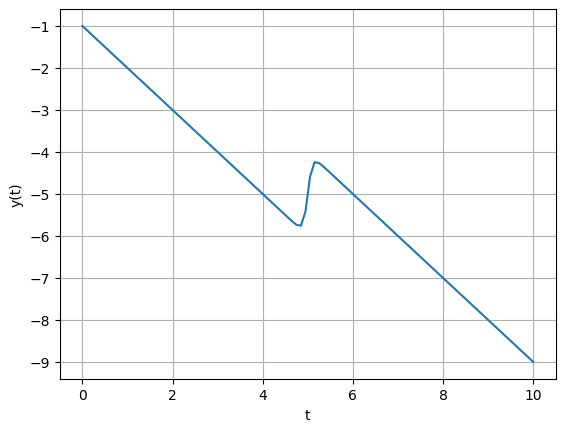

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create a range of t values
t = np.linspace(0, 10, 100)

# Plot the function
plt.plot(t, np.tanh((t-5)/.1) - t)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.grid(True)
plt.show()

*Adaptive* time steppers automatically adjust their step size based on an estimate of the error.

If your timestep has an error $E_{current}$ with stepsize $h_{current}$, and you are aiming for an error tolerance $E_{goal}$ then you can update your step size with a formula like:

$$h_{new} = h_{current} \bigg|\frac{E_{goal}}{E_{current}} \bigg|^\alpha$$

where $\alpha$ is some user value (0.2 is a good choice).

There are remaining quesitons though:
* Would you reject the time step if $E_{current} \gt E_{tolerance}$ and repeat with a new timestep?
* Would you have a *meta* analysis of the solver method to 'catch' non-convergent cases?

There are a few methods to capture the error. Naturally, you don't want the error calculation to be overly burdomsome.
* Change step-size
* Change integration order
* Directly compare $y_i$ to $y_{i+1}$ or other properties of the solution.

### Step-halving methods

Step-halving methods compare the results of a full step to two half steps. For RK4, the error is calculated as:

$$E = y_{double \  step} - y_{single\  step} $$

for this RK4 scheme, one could correct higher accuracy estimate with $$y_{double \  step}^* = y_{double \  step} + \frac{E}{15}$$

Example: Integrate $$y^\prime = 4 e^{0.8x}-0.5y$$ with $y(0) = 2$ from $x = 0\  to\  2$. The analytic answer is 14.84392.

In [1]:
# prompt: solve above with RK4

import numpy as np
import matplotlib.pyplot as plt

def f(x, y):
  """The differential equation."""
  return 4 * np.exp(0.8 * x) - 0.5 * y

def rk4_step(f, x, y, h):
  """Takes a single RK4 step."""
  k1 = h * f(x, y)
  k2 = h * f(x + h/2, y + k1/2)
  k3 = h * f(x + h/2, y + k2/2)
  k4 = h * f(x + h, y + k3)
  return y + (k1 + 2*k2 + 2*k3 + k4) / 6

# Initial conditions
x0 = 0
y0 = 2
x_end = 2
h_initial = 2


y_onestep = rk4_step(f, x0, y0, 2)
print('One stpe with h=2 ', y_onestep)

y_t = rk4_step(f, x0, y0, 1)
y_twostep = rk4_step(f, x0+1, y_t, 1)
print('Two steps with h=1 ', y_twostep)

print('Approximate error is ', (y_twostep - y_onestep)/15, ' vs true error, ', 14.84392 - y_twostep)

One stpe with h=2  15.105846327501714
Two steps with h=1  14.8624835881192
Approximate error is  -0.016224182625500915  vs true error,  -0.018563588119199892


Note that to calculate this value we had to evaluate $f(x,y)$ 8 times.

### Runge-Kutta Fehlberg

Another approach is to compare different integration orders over the same step. This is made efficient by *reusing* function calls between the two approximations.

$$
\begin{array}{c|cccccc}
0 &  &  &  &  &  &  \\
\frac{1}{5} & \frac{1}{5} &  &  &  &  &  \\
\frac{3}{10} & \frac{3}{40} & \frac{9}{40} &  & & &  \\
\frac{3}{5} & \frac{3}{10} & -\frac{9}{10} & \frac{6}{5} &  &  &  \\
1 & -\frac{11}{54} & \frac{5}{2} & -\frac{70}{27} & \frac{35}{27} &  &  \\
\frac{7}{8} & \frac{1631}{55296} & \frac{175}{512} & \frac{575}{13824} & \frac{44275}{110592} & \frac{253}{4096} &  \\
\hline
 & \frac{37}{378} & 0 & \frac{250}{621} & \frac{125}{594} & 0 & \frac{512}{1771} \\
 & \frac{2825}{27648} & 0 & \frac{18575}{48384} & \frac{13525}{55296} & \frac{277}{14336} & \frac{1}{4} \\
\end{array}
$$

where the doubling of the last line means:

$$
\begin{align}
y_{i+1}^{(4)} &= y_i + h \left( \frac{37}{378} k_1 + \frac{250}{621} k_3 + \frac{125}{594} k_4 + \frac{512}{1771} k_6 \right) \\
y_{i+1}^{(5)} &= y_i + h \left( \frac{2825}{27648} k_1 + \frac{18575}{48384} k_3 + \frac{13525}{55296} k_4 + \frac{277}{14336} k_5 + \frac{1}{4} k_6 \right)
\end{align}$$

The error is then simply $y_{i+1}^{(5)} - y_{i+1}^{(4)}$

This is the method of choice for packaged tools. E.g.:

In [2]:
# prompt: solve 4 * np.exp(0.8 * x) - 0.5 * y with scipy , step size 2 and output the error

import numpy as np
from scipy.integrate import solve_ivp

def f(x, y):
  """The differential equation."""
  return 4 * np.exp(0.8 * x) - 0.5 * y

# Initial conditions
x0 = 0
y0 = 2
x_end = 2

# Solve the differential equation using solve_ivp
sol = solve_ivp(f, (x0, x_end), [y0], method='RK45')
print(sol)


# Extract the solution
y_numerical = sol.y[0][-1]

# Analytical solution (you might need to calculate this beforehand)
y_analytical = 14.84392

# Calculate the error
error = abs(y_numerical - y_analytical)

print(f"Numerical solution: {y_numerical}")
print(f"Error: {error}")

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.222e-02  1.014e+00  2.000e+00]
        y: [[ 2.000e+00  2.284e+00  6.279e+00  1.484e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 20
     njev: 0
      nlu: 0
Numerical solution: 14.844062517715555
Error: 0.00014251771555429116


### Direct comparison

A less elegant, but sometimes more pragmatic method is use other metrics to control the step size.

Following a time step, the rate of change can be calculated,  
$$\frac{dy}{dt} = \frac{y_{i+1}-y_i}{h}$$
from which a control on $\|\frac{dy}{dt}\|$ can be placed. E.g.: one could require that the Euclidian or $\infty$ norm be below a tolerance. This method controls the change in solution, rather than its error.  

An even more brute-force method may be to observe the efficiency of the solver. We konw that nonlinear root finding with Newton's method converges quadratically near the root. By monitoring the Newton iterations at each timestep, one can assess if the solver is converging quadratically, or is taking too many iterations which may mean the new time step is too far from the previous one.
